In [1]:
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet('dataset.parquet')

## I. DQA

### 1. Tính đầy đủ 

In [3]:
pd.set_option('display.max_rows', None)

Tỷ lệ missing theo cột

In [4]:
missing_col = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_pct': df.isna().mean() * 100
}).sort_values('missing_pct', ascending=False)

missing_col

,missing_count,missing_pct
INCOME,120000,5.0
DTI_RATIO,0,0.0
CNT_OTHER_PRODUCTS,0,0.0
LIMIT_TO_INCOME,0,0.0
AMT_VAR_6M,0,0.0
CBAL_SHORTTERM_LOAN,0,0.0
CBAL_LONGTERM_LOAN,0,0.0
HAS_LONGTERM_LOAN,0,0.0
CNT_DPD_30PLUS_6M,0,0.0
OCCUPATION_TYPE,0,0.0


In [5]:
pd.set_option('display.max_rows', 20)

Tỷ lệ missing theo row

In [6]:
df['ROW_MISSING_PCT'] = df.isna().mean(axis=1) * 100

df['ROW_MISSING_PCT'].describe()

count    2.400000e+06
mean     1.041667e-01
std      4.540521e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.083333e+00
Name: ROW_MISSING_PCT, dtype: float64

dòng dữ liệu thiếu nhiều thông tin nhất cũng chỉ thiếu khoảng 4.41%, thấp hơn rất nhiều so với ngưỡng 40%

- ebm tự xứ ly được
- log reg xử lý theo woe 

### 2. Tính duy nhất 

Trùng khóa logic (SOCIF – year)

In [7]:
dup_key = df.duplicated(subset=['SOCIF', 'year'], keep=False)

df.loc[dup_key].shape

(0, 49)

Trùng toàn bộ bản ghi (record duplicate)

In [8]:
dup_full = df.duplicated(keep=False)

dup_full.sum()

np.int64(0)

In [9]:
dup_rate = dup_full.mean() * 100
print(f"Tỷ lệ bản ghi trùng lặp: {dup_rate:.2f}%")

Tỷ lệ bản ghi trùng lặp: 0.00%


### 3. Tính phù hợp 

Khoảng giá trị 

In [10]:
# Check xem dòng nào có ratio âm
invalid_ratio = df[df['LIMIT_TO_INCOME'] < 0]
print("Số dòng Limit/Income bị âm:", invalid_ratio.shape[0])

Số dòng Limit/Income bị âm: 0


In [11]:
rule_valid_age = (df['TUOI'].between(0, 120))
df.loc[~rule_valid_age].shape

(0, 49)

In [12]:
rule_valid_ltv = df['LTV'].between(0, 400)

df.loc[~rule_valid_ltv].shape


(0, 49)

In [13]:
rule_valid_duration = ((df['DURATION_MAX'] >= 0) & (df['REMAINING_DURATION_MAX'] >= 0))

df.loc[~rule_valid_duration].shape

(0, 49)

In [14]:
valid_gender = df['C_GIOITINH'].isin(['M', 'F'])
df.loc[~valid_gender].shape

(0, 49)

In [15]:
df['FLAG_INVALID'] = ~(
    rule_valid_age &
    rule_valid_ltv &
    rule_valid_duration &
    valid_gender
)

In [16]:
pd.set_option('display.max_columns', None)

In [17]:
df.describe()

,SOCIF,NHANVIENBIDV,INHERENT_RISK,REF_MONTH,REF_DAY,year,BASE_AUM,CURRENT_RISK,TUOI,SNAPSHOT_DATE,INCOME,CBAL,AFLIMT_AVG,LTV,N_AVG_DEPOSIT_12M,FLAG_SALARY_ACC,FLAG_DEPOSIT,UTILIZATION_RATE,CNT_CREDIT_CARDS,AMT_CASH_ADVANCE_12M,PCT_PAYMENT_TO_BALANCE,CNT_MIN_PAY_6M,AVG_DAYS_PAST_DUE,DTI_RATIO,MOB,CNT_OTHER_PRODUCTS,LIMIT_TO_INCOME,AMT_VAR_6M,CBAL_SHORTTERM_LOAN,CBAL_LONGTERM_LOAN,HAS_LONGTERM_LOAN,CNT_DPD_30PLUS_6M,OCCUPATION_TYPE,DURATION_MAX,REMAINING_DURATION_MAX,TIME_TO_OP_MAX,RATE_AVG,PURCOD_MAX,MAX_DPD_12M,AVG_OD_DPD_12M,BAD_CURRENT,XULYNO,MAX_NHOMNOCIC,N_AVG_OVERDUE_CBAL_12M,BAD_NEXT_12M,ROW_MISSING_PCT
count,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2400000,2.280000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2400000.0,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06
mean,1.200000e+06,1.029750e-02,7.010688e-17,6.498735e+00,1.452080e+01,2.020500e+03,1.040078e+07,1.665974e-01,3.720353e+01,2020-12-29 02:54:56.160000256,2.262860e+07,3.297642e+08,6.804929e+08,1.207265e+02,3.240266e+06,8.624429e-01,5.463367e-01,4.356772e-01,1.494581e+00,5.974919e+07,1.067599e+00,9.637629e-01,2.372091e+00,1.170814e+00,6.251819e+01,5.988854e-01,3.160412e+01,1.089114e-04,1.648788e+08,1.648854e+08,8.747633e-01,2.593213e-01,2.002271e+00,8.211065e+01,4.262277e+01,3.948788e+01,9.366556e+00,4.597413e+00,8.844162e+01,0.0,1.767304e-01,7.234750e-02,1.844410e+00,1.330231e+08,1.308383e-01,1.041667e-01
min,1.000000e+06,0.000000e+00,-1.414093e+00,1.000000e+00,1.000000e+00,2.018000e+03,1.976600e+04,-3.417804e+00,1.800000e+01,2018-01-01 00:00:00,8.036520e+06,0.000000e+00,1.966785e+08,0.000000e+00,7.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,2.400000e+01,-1.031925e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+06,0.000000e+00,-7.346683e-01,4.000000e+00,7.750000e+00,2.019000e+03,2.352022e+06,-6.313609e-01,3.000000e+01,2019-06-28 00:00:00,1.673488e+07,1.623879e+08,4.790737e+08,1.430676e+01,4.265225e+05,1.000000e+00,0.000000e+00,2.690217e-01,1.000000e+00,0.000000e+00,8.233325e-01,0.000000e+00,0.000000e+00,6.758605e-01,3.400000e+01,0.000000e+00,2.752027e+01,-1.349390e-01,3.735344e+07,3.722886e+07,1.000000e+00,0.000000e+00,1.000000e+00,3.600000e+01,1.300000e+01,1.100000e+01,7.452226e+00,2.000000e+00,1.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.200000e+06,0.000000e+00,-2.286553e-01,6.000000e+00,1.500000e+01,2.020500e+03,5.215838e+06,2.903157e-03,3.700000e+01,2020-12-30 00:00:00,2.031191e+07,2.820374e+08,5.978343e+08,2.000000e+02,1.190874e+06,1.000000e+00,1.000000e+00,4.454427e-01,1.000000e+00,0.000000e+00,1.077865e+00,0.000000e+00,0.000000e+00,1.111008e+00,6.300000e+01,0.000000e+00,3.084363e+01,1.673022e-04,1.157428e+08,1.157895e+08,1.000000e+00,0.000000e+00,2.000000e+00,6.000000e+01,2.700000e+01,2.500000e+01,9.114593e+00,6.000000e+00,8.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.123098e+08,0.000000e+00,0.000000e+00
75%,1.299999e+06,0.000000e+00,4.921627e-01,9.000000e+00,2.200000e+01,2.022000e+03,1.153607e+07,7.871727e-01,4.400000e+01,2022-06-28 00:00:00,2.520432e+07,4.413033e+08,7.704713e+08,2.000000e+02,3.199729e+06,1.000000e+00,1.000000e+00,6.306674e-01,2.000000e+00,0.000000e+00,1.323501e+00,1.000000e+00,2.000000e+00,1.619395e+00,9.100000e+01,1.000000e+00,3.406661e+01,1.35035

In [18]:
pd.set_option('display.max_columns', 20)

Định dạng 

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 50 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   SOCIF                   int64         
 1   C_GIOITINH              object        
 2   TTHONNHAN               object        
 3   NHANVIENBIDV            int64         
 4   INHERENT_RISK           float64       
 5   REF_MONTH               int32         
 6   REF_DAY                 int32         
 7   year                    int64         
 8   BASE_AUM                int64         
 9   CURRENT_RISK            float64       
 10  TUOI                    int64         
 11  SNAPSHOT_DATE           datetime64[ns]
 12  INCOME                  float64       
 13  CBAL                    int64         
 14  AFLIMT_AVG              int64         
 15  LTV                     float64       
 16  N_AVG_DEPOSIT_12M       int64         
 17  FLAG_SALARY_ACC         int64         
 18  FL

Các biến cần khi báo là cate khi binning: 
- Dạng object sẵn: C_GIOITINH, TTHONNHAN
- Dạng int: PURCOD_MAX, PURCOD_MIN, OCCUPATION_TYPE, TRINHDO, MAX_NHOMNOCIC

### Bảng tổng hợp 

In [20]:
quality_summary = pd.DataFrame({
    'Metric': [
        'Uniqueness',
        'Validity'
    ],
    'Issue_Rate_%': [
        dup_full.mean() * 100,
        df['FLAG_INVALID'].mean() * 100
    ]
})

quality_summary

,Metric,Issue_Rate_%
0,Uniqueness,0.0
1,Validity,0.0


In [21]:
flag_cols = [c for c in df.columns if c.startswith('FLAG_')]

dq_flag_impact = []

for c in flag_cols:
    tmp = df.groupby(c)['BAD_NEXT_12M'].mean()
    dq_flag_impact.append({
        'FLAG': c,
        'BAD_RATE_0': tmp.get(0, np.nan),
        'BAD_RATE_1': tmp.get(1, np.nan),
        'LIFT': tmp.get(1, np.nan) / tmp.get(0, np.nan)
    })

dq_flag_impact = pd.DataFrame(dq_flag_impact).sort_values('LIFT', ascending=False)
dq_flag_impact

,FLAG,BAD_RATE_0,BAD_RATE_1,LIFT
0,FLAG_SALARY_ACC,0.269634,0.108701,0.403143
1,FLAG_DEPOSIT,0.246649,0.034673,0.140575
2,FLAG_INVALID,0.130838,NaN,NaN


In [22]:
dqa_cols_to_drop = [
    'FLAG_INVALID'
]
df.drop(columns=[c for c in dqa_cols_to_drop if c in df.columns], inplace=True)

In [23]:
print("Lọc bỏ hồ sơ rác & Đã xấu")

cond_remove = (
    (df['BAD_CURRENT'] == 1) |      # Loại người đang Bad
    (df['MAX_NHOMNOCIC'] >= 3) |    # Loại nhóm nợ xấu
    (df['XULYNO'] == 1) |           # Loại đã xử lý nợ
    (df['TUOI'] < 18) |   
    (df['TUOI'] > 80) |
    (df['DTI_RATIO'] > 100) |                            # Loại trẻ em
    (df['CBAL'] <= 100000) |             # Loại không có dư nợ (Inactive)
    (df['INCOME'] <= 0)
)

df = df[~cond_remove].copy()

Lọc bỏ hồ sơ rác & Đã xấu


In [24]:
df.drop(['ROW_MISSING_PCT', 'SOCIF', 'SNAPSHOT_DATE', 'REF_MONTH', 'REF_DAY', 'BAD_CURRENT', 'XULYNO', 'INHERENT_RISK', 'CURRENT_RISK', 'year'], axis=1, inplace=True)

In [25]:
target_col = 'BAD_NEXT_12M'
remove_cols = [target_col, 'SAMPLE_TYPE'] # Loại bỏ Target và nhãn chia tập khỏi X
    
train = df[df['SAMPLE_TYPE'] == 'TRAIN'].drop(columns='SAMPLE_TYPE')
oos   = df[df['SAMPLE_TYPE'] == 'OOS'].drop(columns='SAMPLE_TYPE')
oot   = df[df['SAMPLE_TYPE'] == 'OOT'].drop(columns='SAMPLE_TYPE')

In [26]:
train.columns

Index(['C_GIOITINH', 'TTHONNHAN', 'NHANVIENBIDV', 'BASE_AUM', 'TUOI', 'INCOME',
       'CBAL', 'AFLIMT_AVG', 'LTV', 'N_AVG_DEPOSIT_12M', 'FLAG_SALARY_ACC',
       'FLAG_DEPOSIT', 'UTILIZATION_RATE', 'CNT_CREDIT_CARDS',
       'AMT_CASH_ADVANCE_12M', 'PCT_PAYMENT_TO_BALANCE', 'CNT_MIN_PAY_6M',
       'AVG_DAYS_PAST_DUE', 'DTI_RATIO', 'MOB', 'CNT_OTHER_PRODUCTS',
       'LIMIT_TO_INCOME', 'AMT_VAR_6M', 'CBAL_SHORTTERM_LOAN',
       'CBAL_LONGTERM_LOAN', 'HAS_LONGTERM_LOAN', 'CNT_DPD_30PLUS_6M',
       'OCCUPATION_TYPE', 'DURATION_MAX', 'REMAINING_DURATION_MAX',
       'TIME_TO_OP_MAX', 'RATE_AVG', 'PURCOD_MAX', 'MAX_DPD_12M',
       'AVG_OD_DPD_12M', 'MAX_NHOMNOCIC', 'N_AVG_OVERDUE_CBAL_12M',
       'BAD_NEXT_12M'],
      dtype='object')

## II. EDA

#### 1. Target analysis 

In [27]:
bad_rate_train = len(df[df['BAD_NEXT_12M'] == 1]) / len(df)
bad_rate_oos = len(oos[oos['BAD_NEXT_12M'] == 1]) / len(oos)
bad_rate_oot = len(oot[oot['BAD_NEXT_12M'] == 1]) / len(oot)

print(f"Bad rate tập train {bad_rate_train}")
print(f"Bad rate tập oos {bad_rate_oos}")   
print(f"Bad rate tập oot {bad_rate_oot}")

Bad rate tập train 0.0700065565782132
Bad rate tập oos 0.06288022323078614
Bad rate tập oot 0.06006692859956374


#### 3. Distribution 

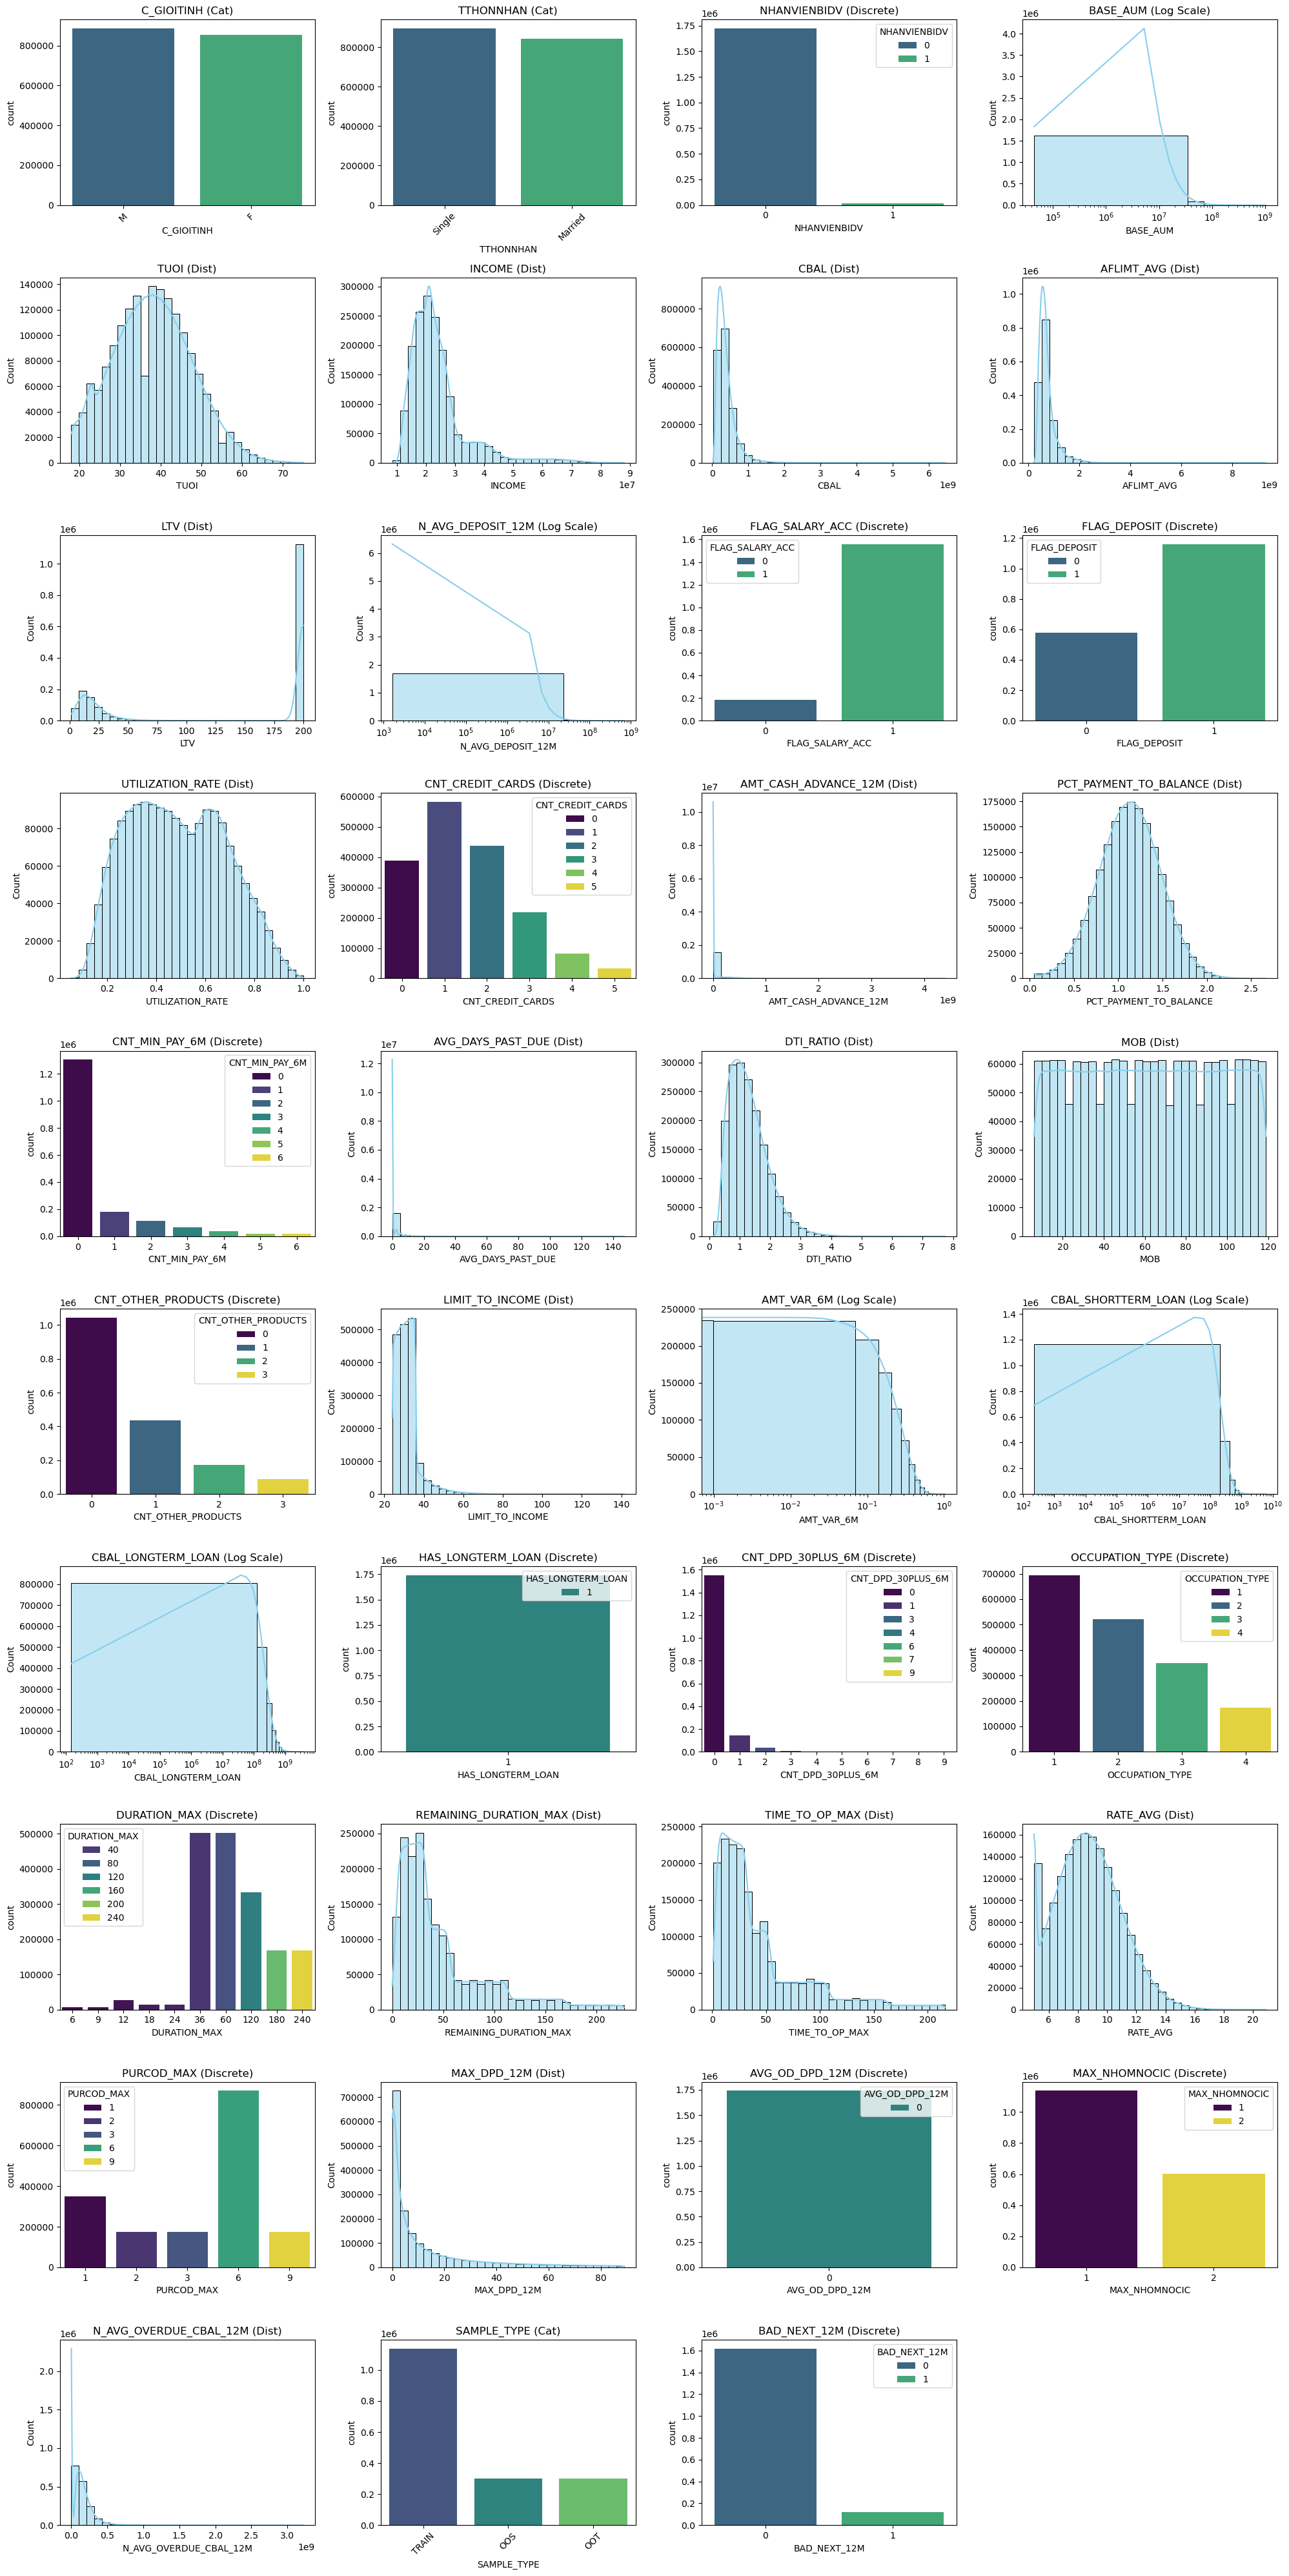

In [28]:
n_cols = 4  # Số biểu đồ trên 1 hàng (bạn có thể đổi thành 3 hoặc 5)
n_rows = math.ceil(len(df.columns) / n_cols)

plt.figure(figsize=(20, 4 * n_rows)) # Chiều cao tự dãn theo số lượng biến

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # CASE A: Biến số (Numeric) -> Vẽ Histogram
    if pd.api.types.is_numeric_dtype(df[col]):
        # Nếu ít giá trị unique (VD: < 10) -> Coi như biến phân loại (Countplot)
        if df[col].nunique() < 15:
            sns.countplot(data=df, x=col, hue=col, palette='viridis')
            plt.title(f'{col} (Discrete)')
        else:
            # Vẽ Histogram + KDE
            sns.histplot(df[col], bins=30, kde=True, color='skyblue')
            plt.title(f'{col} (Dist)')
            
            # Tự động bật Log-scale nếu giá trị quá lớn (tiền tệ)
            # Logic: Nếu max > 100 lần min dương -> Scale Log cho dễ nhìn
            data_min = df[df[col] > 0][col].min()
            data_max = df[col].max()
            if data_min > 0 and (data_max / data_min > 1000):
                plt.xscale('log')
                plt.title(f'{col} (Log Scale)')
                
    # CASE B: Biến phân loại (Categorical/Object) -> Vẽ Countplot
    else:
        sns.countplot(data=df, x=col, hue=col, palette='viridis')
        plt.title(f'{col} (Cat)')
        plt.xticks(rotation=45) # Xoay nhãn nếu dài

plt.tight_layout()
plt.show()

- C_GIOITINH: Phân phối gần như 50/50.
- TRINHDO: Level 1–4 phân bố theo dạng đa modal, trong đó Level 2–3 chiếm tỷ trọng lớn nhất. 
- TTHONNHAN: Phân phối gần 50–50 giữa độc thân và đã kết hôn.
- SOHUUNHA: Hai cụm 0 và 1, tỷ lệ gần 60/40.
- TUOI: Tuổi rơi vào khoảng 18–70. Phân phối lệch phải phù hợp với thực tế:
    - Độ tuổi vay vốn phổ biến nhất thường rơi vào 30 - 40 tuổi (đỉnh của phân phối).
    - Sau 50-60 tuổi, nhu cầu vay giảm dần 
- BASE_AUM (đã được lấy log):Right-skew rất mạnh, với tail rất dài. Chênh lệnh lớn giữa các khách hàng: 80% tài sản nằm trong tay 20% khách hàng
- INCOME: right-skew. Đuôi dài đến 10–20M/tháng.
- CBAL: right-skew mạnh.
- CBALLOG: gần chuẩn normal → EXACTLY như kỳ vọng. Phân phối cực kỳ chuẩn cho loan balance.
- AFLIMT_MAX / AFLIMT_MIN: Hai biến này phân phối theo dạng hai đỉnh (capped & small limit). Đúng hành vi cấp hạn mức thẻ/vay tín chấp.
- AMT_AVG / CBAL_AVG / CBAL_MAX / CBAL_MIN: Tất cả đều right-skew, tail khá dài. Đúng thực tế.
- COLLATERAL_VALUE: Phân phối rất gần dữ liệu thật. Hai đỉnh rõ:
    - Nhóm không nhà (≈ 0.5–1B)
    - Nhóm có nhà (≈2–3B)
- LTV: Dạng phân phối rất lệch phải. Tail vượt 150–200%. Đúng thực tế vì có khách nợ xấu → LTV >100%.
- N_AVG_DEPOSIT_12M, N_AVG_DEPOSIT_6M: Trục log → log-normal. Tail rất dài. Đẹp, thực tế
- DD/CD SPENDING: Gần giống deposit nhưng nhỏ hơn. Tail mượt. Phù hợp.
- FLAG_SALARY_ACC / FLAG_DEPOSIT: Khoảng 50–60% có lương chuyển khoản. Chuẩn retail ngân hàng.
- UTILIZATION_RATE: dạng uniform lượn sóng trong 0.0–1.0. Nhiều ở khoảng 0.3–0.6 → đúng thực tế. Rất hợp lý. Thẻ tín dụng thường có “multi-modal” behavior như vậy.
- CNT_CREDIT_CARDS: Poisson-like, peak tại 1–2 thẻ, có người 0–5 thẻ. Chuẩn.
- CASH ADVANCE (AMT) & FLAG: 20–40% có cash advance. Distribution tail dài (vài triệu). Giống dữ liệu CIC thẻ tín dụng.
- PCT_PAYMENT_TO_BALANCE: Chuông chuẩn quanh 1.0 (pay full). Có tail trái → trả ít → khách rủi ro.
- CNT_MIN_PAY_6M: Poisson + heavy right tail. Khoảng 0–3 là phổ biến.
- AVG_DAYS_PAST_DUE: Exponential-like → tail dài. Chuẩn dữ liệu CIC.
- DTI_RATIO: Right-skew; peak khoảng 0.2–0.4. Tail lên tới 1.0–2.0 Đúng IFRS9.
- LIMIT_TO_INCOME: Right-skew. Trông đẹp và hợp lý.
- PTI_RATIO: Chuông lệch phải. Peak ~0.2–0.3. Reality-alike.
- MOB: Uniform pha chút gợn (không quá đều)
- CNT_OTHER_PRODUCTS: Tập trung tại 0–1. Giống khách mass.
- OCCUPATION_TYPE: Có 3 nhóm, phân phối Poisson-like. Ổn nhưng nghề còn hơi random, có thể thêm cấu trúc ngành.
- LOAN STRUCTURE: Đúng thị trường vay Việt Nam. Hai cụm:
    - Short-term: 6–24 tháng
    - Long-term: 36–240 tháng
- DURATION / REMAINING_DURATION: Bimodal rõ rệt. Tail dài nếu long-term. Perfectly realistic.
- RATE_AVG: Chuông lệch phải 5–20%. Magnum peak tại 13–15%. Đúng thị trường consumer loan VN.
- MAX_DPD, AVG_DPD, SUM_ODD_DPD: Heavy tail, Spike tại 0
- N_AVG_OVERDUE_CBAL_12M: Hầu hết = 0, tail đến 4–5.
– REAL_GDP_GROWTH: Multi-modal nhẹ theo 6 năm
– BAD_NEXT_12M: Bad rate khoảng 5–8%. Tỷ lệ rất cân đối (không quá nhỏ → mô hình dễ train).

#### 4. Kiểm tra outlier 

- Các outlier này là ngoại lai tự nhiên (Natural Outliers) đặc trưng của dữ liệu tài chính, phản ánh sự phân hóa mạnh về thu nhập và hành vi khách hàng, không phải lỗi dữ liệu nên được giữ nguyên để đảm bảo tính phân loại. Các biến này sẽ được xử lý tự động thông qua thuật toán Optimal Binning, mà không cần xử lý thủ công 
- ebm không cần xứ lý outlier 

In [29]:
# 1. Xác định danh sách biến cần check (Biến số - trừ ID và Target)
exclude_cols = ['SOCIF', 'BAD_NEXT_12M', 'REF_MONTH', 'REF_DAY', 'year', 'SNAPSHOT_DATE', 'TRINHDO', 'OCCUPATION_TYPE', 'PURCOD_MAX', 'PURCOD_MIN', 'MAX_NHOMNOCIC', 'NHANVIENBIDV', 'SOHUUNHA', 'FLAG_SALARY_ACC', 'FLAG_DEPOSIT', 'FLAG_CASH_ADVANCE', 'BAD_CURRENT', 'XULYNO', 'HAS_SHORTTERM_LOAN', 'HAS_LONGTERM_LOAN']
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Loại bỏ các biến Flag (chỉ có 0 và 1) và biến ID
cols_to_check = [c for c in numeric_cols if c not in exclude_cols and df[c].nunique() > 10] 

# 2. Tạo báo cáo Outlier
outlier_report = []

for col in cols_to_check:
    # Tính các mốc thống kê
    p01 = df[col].quantile(0.01)
    p99 = df[col].quantile(0.99)
    v_min = df[col].min()
    v_max = df[col].max()
    
    # Logic phát hiện nghi vấn:
    # 1. Max quá lớn so với P99 (Gấp 5 lần trở lên) -> Có thể là Outlier hoặc mã đặc biệt
    # 2. Min quá nhỏ (Số âm cho biến tiền tệ)
    
    is_suspicious = False
    note = ""
    
    # Check Max spike
    if (v_max > p99 * 5) and (v_max > 0): # Gấp 5 lần
        is_suspicious = True
        note += "Max cực lớn (Gap > 5x P99). "
        
    # Check Negative (cho biến tiền, trừ biến động có thể âm)
    if v_min < 0 and 'VAR' not in col: # VAR có thể âm
        is_suspicious = True
        note += "Có giá trị Âm. "

    if is_suspicious:
        outlier_report.append({
            'Variable': col,
            'Min': v_min,
            'P99': p99,
            'Max': v_max,
            'Max/P99 Ratio': round(v_max / p99 if p99 > 0 else 0, 1),
            'Note': note
        })

# 3. In kết quả
df_outlier = pd.DataFrame(outlier_report)
print(f"Tìm thấy {len(df_outlier)} biến có dấu hiệu Outlier mạnh:")
df_outlier.sort_values(by='Max/P99 Ratio', ascending=False)

Tìm thấy 6 biến có dấu hiệu Outlier mạnh:


,Variable,Min,P99,Max,Max/P99 Ratio,Note
1,N_AVG_DEPOSIT_12M,1618,3.576248e+07,692326582,19.4,Max cực lớn (Gap > 5x P99).
0,BASE_AUM,44169,8.956323e+07,1036089773,11.6,Max cực lớn (Gap > 5x P99).
3,AVG_DAYS_PAST_DUE,0,1.800000e+01,147,8.2,Max cực lớn (Gap > 5x P99).
4,CBAL_SHORTTERM_LOAN,223,8.563992e+08,6150339714,7.2,Max cực lớn (Gap > 5x P99).
2,AMT_CASH_ADVANCE_12M,0,6.902166e+08,4399059484,6.4,Max cực lớn (Gap > 5x P99).
5,N_AVG_OVERDUE_CBAL_12M,0,6.088609e+08,3220969003,5.3,Max cực lớn (Gap > 5x P99).


### III. Bivariate Analysis

#### 1. Multicollinearity

- log reg bắt buộc xử lý multicollinearity 
- ebm không bắt buộc phải bỏ vì đã robust với multicollinearity

=> kiểm tra qua multicollinearity ở bước này, ở các segment ở multicolliearitysex xử lý kĩ hơn.

In [30]:
y_train = df['BAD_NEXT_12M']
X = df.drop('BAD_NEXT_12M', axis=1)
y_oos = oos['BAD_NEXT_12M']
X_oos = oos.drop('BAD_NEXT_12M', axis=1)
y_oot = oot['BAD_NEXT_12M']
X_oot = oot.drop('BAD_NEXT_12M', axis=1)
# 1. Chỉ chọn các biến số (Numeric) để tính toán
numeric_cols = X.select_dtypes(include=[np.number]).columns
corr_matrix = X[numeric_cols].corr().abs() # Lấy trị tuyệt đối (âm hay dương đều là tương quan mạnh)

# 2. Chọn ngưỡng cắt (Threshold)
# Với EBM, ngưỡng an toàn là 0.7. Ngưỡng 0.8 là bắt buộc phải xử lý.
threshold = 0.7

# 3. Lọc ra các cặp biến vượt ngưỡng
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Tạo danh sách chi tiết để bạn dễ quyết định giữ ai/bỏ ai
high_corr_pairs = []
for col in upper.columns:
    high_cols = upper.index[upper[col] > threshold].tolist()
    for row in high_cols:
        val = upper.loc[row, col]
        high_corr_pairs.append((row, col, val))

# Sắp xếp theo độ tương quan giảm dần
high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

# 4. In kết quả
print(f"Tìm thấy {len(high_corr_pairs)} cặp biến tương quan cao (> {threshold}):")
print("-" * 60)
print(f"{'Biến 1 (Giữ?)':<30} | {'Biến 2 (Bỏ?)':<30} | {'Corr':<10}")
print("-" * 60)
for pair in high_corr_pairs:
    print(f"{pair[0]:<30} | {pair[1]:<30} | {pair[2]:.4f}")

Tìm thấy 9 cặp biến tương quan cao (> 0.7):
------------------------------------------------------------
Biến 1 (Giữ?)                  | Biến 2 (Bỏ?)                   | Corr      
------------------------------------------------------------
INCOME                         | AFLIMT_AVG                     | 0.8989
UTILIZATION_RATE               | DTI_RATIO                      | 0.8713
BASE_AUM                       | N_AVG_DEPOSIT_12M              | 0.7909
DURATION_MAX                   | REMAINING_DURATION_MAX         | 0.7830
CBAL                           | AFLIMT_AVG                     | 0.7635
MAX_DPD_12M                    | MAX_NHOMNOCIC                  | 0.7525
DURATION_MAX                   | TIME_TO_OP_MAX                 | 0.7509
CBAL                           | DTI_RATIO                      | 0.7234
CBAL                           | N_AVG_OVERDUE_CBAL_12M         | 0.7041


In [31]:
print(f"TRAIN: {train.shape}")
print(f"OOS: {oos.shape}")
print(f"OOT: {oot.shape}")

train.to_parquet('train.parquet', index=False)
oos.to_parquet('oos.parquet', index=False)
oot.to_parquet('oot.parquet', index=False)

TRAIN: (1137807, 38)
OOS: (300317, 38)
OOT: (302113, 38)
